# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

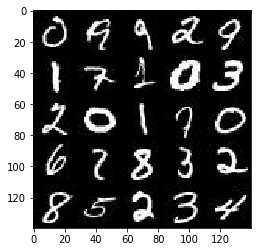

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

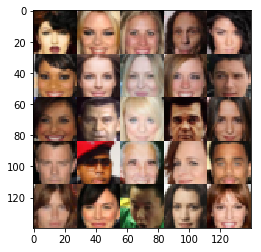

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [78]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="real_input")
    z_input = tf.placeholder(tf.float32, (None, z_dim), name="z_input")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")

    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [79]:
def LRelu(x, alpha=0.2):
    return tf.maximum(x*alpha, x)

    
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    kinit = tf.random_normal_initializer(stddev=0.02)
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28xchannels
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, kernel_initializer=kinit, padding='same')
        relu1 = LRelu(x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, kernel_initializer=kinit, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = LRelu(bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, kernel_initializer=kinit, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = LRelu(bn3)
        # 4x4x256

        # Flat
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [93]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    kinit = tf.random_normal_initializer(stddev=0.02)
    
    with tf.variable_scope('generator', reuse=not is_train):
        # Fully connected
        x1 = tf.layers.dense(z, 7*7*128)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 128))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = LRelu(x1)

        # 7x7x128 now

        x2 = tf.layers.conv2d_transpose(x1, 64, 5, strides=2, kernel_initializer=kinit, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = LRelu(x2)

        # 14x14x64 now

        x3 = tf.layers.conv2d_transpose(x2, 32, 5, strides=1, kernel_initializer=kinit, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = LRelu(x3)

        # 14x14x32 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, kernel_initializer=kinit, padding='same')

        # 28x28xout_channel_dim now

        out = tf.tanh(logits)

        return out    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [94]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss    
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [95]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [96]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [97]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #saver = tf.train.Saver()    
    
    print_every = 20
    steps = 0
    
    input_real, input_z, l_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, l_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, l_rate: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

            # After every epoc
            show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)    
                    
        #saver.save(sess, './checkpoints/generator.ckpt')                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/10... Discriminator Loss: 1.1181... Generator Loss: 6.5631
Epoch 1/10... Discriminator Loss: 0.0941... Generator Loss: 3.8916
Epoch 1/10... Discriminator Loss: 1.5881... Generator Loss: 0.3285
Epoch 1/10... Discriminator Loss: 0.1552... Generator Loss: 2.6285
Epoch 1/10... Discriminator Loss: 0.0772... Generator Loss: 3.4293
Epoch 1/10... Discriminator Loss: 0.0627... Generator Loss: 4.2709
Epoch 1/10... Discriminator Loss: 0.2973... Generator Loss: 1.9949
Epoch 1/10... Discriminator Loss: 0.1773... Generator Loss: 3.0044
Epoch 1/10... Discriminator Loss: 0.1201... Generator Loss: 3.1034
Epoch 1/10... Discriminator Loss: 0.1649... Generator Loss: 2.8800
Epoch 1/10... Discriminator Loss: 0.1446... Generator Loss: 2.6812
Epoch 1/10... Discriminator Loss: 0.6621... Generator Loss: 5.2769
Epoch 1/10... Discriminator Loss: 0.1716... Generator Loss: 3.0975
Epoch 1/10... Discriminator Loss: 5.3942... Generator Loss: 0.0088
Epoch 1/10... Discriminator Loss: 0.1468... Generator Loss: 2.

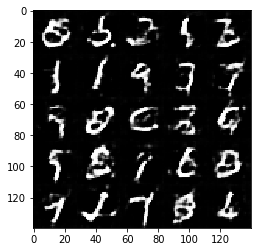

Epoch 2/10... Discriminator Loss: 0.3810... Generator Loss: 1.8993
Epoch 2/10... Discriminator Loss: 0.4363... Generator Loss: 1.5833
Epoch 2/10... Discriminator Loss: 0.4465... Generator Loss: 2.0140
Epoch 2/10... Discriminator Loss: 0.6807... Generator Loss: 3.2054
Epoch 2/10... Discriminator Loss: 0.5678... Generator Loss: 1.2992
Epoch 2/10... Discriminator Loss: 0.4491... Generator Loss: 1.9621
Epoch 2/10... Discriminator Loss: 0.5277... Generator Loss: 2.0916
Epoch 2/10... Discriminator Loss: 0.9042... Generator Loss: 1.3306
Epoch 2/10... Discriminator Loss: 0.7900... Generator Loss: 0.8690
Epoch 2/10... Discriminator Loss: 0.6231... Generator Loss: 1.7585
Epoch 2/10... Discriminator Loss: 0.8747... Generator Loss: 0.6780
Epoch 2/10... Discriminator Loss: 0.4780... Generator Loss: 1.3027
Epoch 2/10... Discriminator Loss: 0.5294... Generator Loss: 1.3832
Epoch 2/10... Discriminator Loss: 0.7903... Generator Loss: 0.8391
Epoch 2/10... Discriminator Loss: 1.4325... Generator Loss: 0.

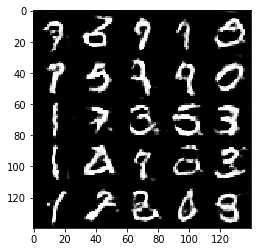

Epoch 3/10... Discriminator Loss: 0.5177... Generator Loss: 1.2872
Epoch 3/10... Discriminator Loss: 0.4613... Generator Loss: 1.5000
Epoch 3/10... Discriminator Loss: 0.4620... Generator Loss: 1.3536
Epoch 3/10... Discriminator Loss: 0.5489... Generator Loss: 1.1855
Epoch 3/10... Discriminator Loss: 0.3229... Generator Loss: 1.7042
Epoch 3/10... Discriminator Loss: 0.9807... Generator Loss: 0.6371
Epoch 3/10... Discriminator Loss: 0.6520... Generator Loss: 2.1081
Epoch 3/10... Discriminator Loss: 0.4910... Generator Loss: 1.4353
Epoch 3/10... Discriminator Loss: 0.5171... Generator Loss: 1.2295
Epoch 3/10... Discriminator Loss: 0.8155... Generator Loss: 0.7844
Epoch 3/10... Discriminator Loss: 0.3872... Generator Loss: 1.5031
Epoch 3/10... Discriminator Loss: 0.4642... Generator Loss: 1.3878
Epoch 3/10... Discriminator Loss: 0.3223... Generator Loss: 1.7424
Epoch 3/10... Discriminator Loss: 0.5452... Generator Loss: 1.1771
Epoch 3/10... Discriminator Loss: 1.0519... Generator Loss: 0.

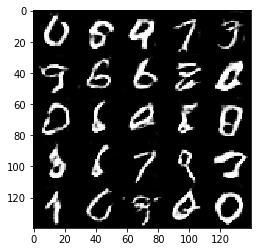

Epoch 4/10... Discriminator Loss: 0.7025... Generator Loss: 0.9269
Epoch 4/10... Discriminator Loss: 0.4165... Generator Loss: 1.7967
Epoch 4/10... Discriminator Loss: 0.3271... Generator Loss: 1.9692
Epoch 4/10... Discriminator Loss: 0.4282... Generator Loss: 1.4435
Epoch 4/10... Discriminator Loss: 0.4404... Generator Loss: 1.3319
Epoch 4/10... Discriminator Loss: 1.0108... Generator Loss: 0.7036
Epoch 4/10... Discriminator Loss: 0.6936... Generator Loss: 0.9881
Epoch 4/10... Discriminator Loss: 0.1863... Generator Loss: 2.3154
Epoch 4/10... Discriminator Loss: 0.4701... Generator Loss: 1.2871
Epoch 4/10... Discriminator Loss: 0.2931... Generator Loss: 2.0369
Epoch 4/10... Discriminator Loss: 0.6898... Generator Loss: 0.9922
Epoch 4/10... Discriminator Loss: 0.1681... Generator Loss: 2.5298
Epoch 4/10... Discriminator Loss: 0.4094... Generator Loss: 1.4948
Epoch 4/10... Discriminator Loss: 3.2056... Generator Loss: 0.1192
Epoch 4/10... Discriminator Loss: 0.5120... Generator Loss: 1.

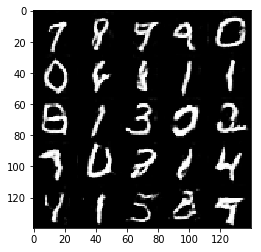

Epoch 5/10... Discriminator Loss: 1.0844... Generator Loss: 0.7662
Epoch 5/10... Discriminator Loss: 0.3071... Generator Loss: 1.7254
Epoch 5/10... Discriminator Loss: 0.3614... Generator Loss: 1.5734
Epoch 5/10... Discriminator Loss: 0.4012... Generator Loss: 1.4798
Epoch 5/10... Discriminator Loss: 0.3285... Generator Loss: 1.6432
Epoch 5/10... Discriminator Loss: 0.3988... Generator Loss: 1.4923
Epoch 5/10... Discriminator Loss: 0.2909... Generator Loss: 1.8752
Epoch 5/10... Discriminator Loss: 0.4521... Generator Loss: 1.3870
Epoch 5/10... Discriminator Loss: 0.3606... Generator Loss: 3.0476
Epoch 5/10... Discriminator Loss: 0.4649... Generator Loss: 1.7338
Epoch 5/10... Discriminator Loss: 0.5050... Generator Loss: 1.2586
Epoch 5/10... Discriminator Loss: 0.5581... Generator Loss: 1.4916
Epoch 5/10... Discriminator Loss: 0.2019... Generator Loss: 2.1408
Epoch 5/10... Discriminator Loss: 0.6281... Generator Loss: 0.9839
Epoch 5/10... Discriminator Loss: 0.9087... Generator Loss: 1.

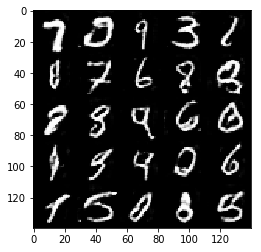

Epoch 6/10... Discriminator Loss: 0.3870... Generator Loss: 1.5202
Epoch 6/10... Discriminator Loss: 0.5058... Generator Loss: 1.2992
Epoch 6/10... Discriminator Loss: 0.3994... Generator Loss: 1.9226
Epoch 6/10... Discriminator Loss: 0.4739... Generator Loss: 1.3839
Epoch 6/10... Discriminator Loss: 0.3868... Generator Loss: 1.5544
Epoch 6/10... Discriminator Loss: 0.3280... Generator Loss: 2.1495
Epoch 6/10... Discriminator Loss: 0.5111... Generator Loss: 1.1834
Epoch 6/10... Discriminator Loss: 0.4137... Generator Loss: 1.4257
Epoch 6/10... Discriminator Loss: 0.2918... Generator Loss: 1.7769
Epoch 6/10... Discriminator Loss: 0.3359... Generator Loss: 1.6729
Epoch 6/10... Discriminator Loss: 0.8861... Generator Loss: 0.8436
Epoch 6/10... Discriminator Loss: 1.1816... Generator Loss: 2.0478
Epoch 6/10... Discriminator Loss: 0.7397... Generator Loss: 1.0431
Epoch 6/10... Discriminator Loss: 0.5081... Generator Loss: 2.3878
Epoch 6/10... Discriminator Loss: 0.6696... Generator Loss: 1.

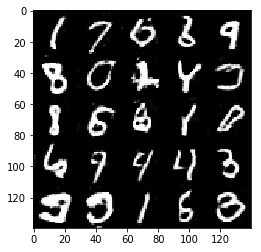

Epoch 7/10... Discriminator Loss: 0.4875... Generator Loss: 3.9260
Epoch 7/10... Discriminator Loss: 0.3225... Generator Loss: 1.7218
Epoch 7/10... Discriminator Loss: 0.4054... Generator Loss: 1.5197
Epoch 7/10... Discriminator Loss: 0.3519... Generator Loss: 1.6594
Epoch 7/10... Discriminator Loss: 0.2430... Generator Loss: 2.0514
Epoch 7/10... Discriminator Loss: 0.2678... Generator Loss: 1.9089
Epoch 7/10... Discriminator Loss: 0.6367... Generator Loss: 1.0593
Epoch 7/10... Discriminator Loss: 0.3793... Generator Loss: 1.4847
Epoch 7/10... Discriminator Loss: 0.2828... Generator Loss: 1.8492
Epoch 7/10... Discriminator Loss: 0.3255... Generator Loss: 1.7805
Epoch 7/10... Discriminator Loss: 1.7985... Generator Loss: 0.2728
Epoch 7/10... Discriminator Loss: 0.4409... Generator Loss: 2.6500
Epoch 7/10... Discriminator Loss: 0.2867... Generator Loss: 1.8350
Epoch 7/10... Discriminator Loss: 0.4027... Generator Loss: 1.5584
Epoch 7/10... Discriminator Loss: 0.3692... Generator Loss: 1.

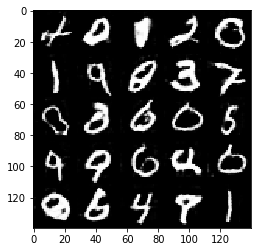

Epoch 8/10... Discriminator Loss: 0.4867... Generator Loss: 1.2359
Epoch 8/10... Discriminator Loss: 0.7103... Generator Loss: 4.9776
Epoch 8/10... Discriminator Loss: 1.4461... Generator Loss: 4.6552
Epoch 8/10... Discriminator Loss: 0.5042... Generator Loss: 1.6699
Epoch 8/10... Discriminator Loss: 0.2862... Generator Loss: 1.9813
Epoch 8/10... Discriminator Loss: 0.4288... Generator Loss: 1.5735
Epoch 8/10... Discriminator Loss: 0.3392... Generator Loss: 1.6864
Epoch 8/10... Discriminator Loss: 0.3539... Generator Loss: 1.6115
Epoch 8/10... Discriminator Loss: 0.4324... Generator Loss: 1.3486
Epoch 8/10... Discriminator Loss: 0.2007... Generator Loss: 2.2513
Epoch 8/10... Discriminator Loss: 0.3688... Generator Loss: 1.5896
Epoch 8/10... Discriminator Loss: 0.5419... Generator Loss: 1.1965
Epoch 8/10... Discriminator Loss: 0.3137... Generator Loss: 1.6988
Epoch 8/10... Discriminator Loss: 0.3381... Generator Loss: 1.6801
Epoch 8/10... Discriminator Loss: 0.2115... Generator Loss: 2.

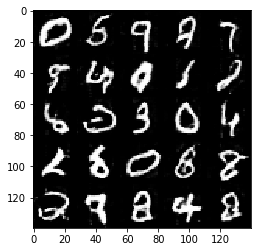

Epoch 9/10... Discriminator Loss: 0.5613... Generator Loss: 1.2614
Epoch 9/10... Discriminator Loss: 0.2453... Generator Loss: 2.3006
Epoch 9/10... Discriminator Loss: 0.5300... Generator Loss: 1.2473
Epoch 9/10... Discriminator Loss: 0.6777... Generator Loss: 2.7335
Epoch 9/10... Discriminator Loss: 0.6314... Generator Loss: 1.1639
Epoch 9/10... Discriminator Loss: 0.4312... Generator Loss: 1.3948
Epoch 9/10... Discriminator Loss: 0.3337... Generator Loss: 1.6168
Epoch 9/10... Discriminator Loss: 0.3471... Generator Loss: 1.6202
Epoch 9/10... Discriminator Loss: 0.3617... Generator Loss: 1.7586
Epoch 9/10... Discriminator Loss: 0.3394... Generator Loss: 1.7004
Epoch 9/10... Discriminator Loss: 0.8512... Generator Loss: 3.9804
Epoch 9/10... Discriminator Loss: 0.6882... Generator Loss: 0.9746
Epoch 9/10... Discriminator Loss: 0.6794... Generator Loss: 0.9538
Epoch 9/10... Discriminator Loss: 0.3764... Generator Loss: 1.4550
Epoch 9/10... Discriminator Loss: 0.2831... Generator Loss: 2.

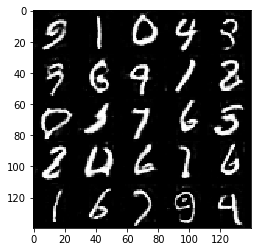

Epoch 10/10... Discriminator Loss: 0.4896... Generator Loss: 1.3710
Epoch 10/10... Discriminator Loss: 0.4434... Generator Loss: 1.3517
Epoch 10/10... Discriminator Loss: 1.0773... Generator Loss: 0.6777
Epoch 10/10... Discriminator Loss: 0.1869... Generator Loss: 2.4182
Epoch 10/10... Discriminator Loss: 0.3072... Generator Loss: 1.6592
Epoch 10/10... Discriminator Loss: 0.5564... Generator Loss: 1.1769
Epoch 10/10... Discriminator Loss: 0.3166... Generator Loss: 1.6869
Epoch 10/10... Discriminator Loss: 0.4314... Generator Loss: 1.3841
Epoch 10/10... Discriminator Loss: 0.2009... Generator Loss: 2.1995
Epoch 10/10... Discriminator Loss: 0.2794... Generator Loss: 2.1635
Epoch 10/10... Discriminator Loss: 0.3480... Generator Loss: 1.9915
Epoch 10/10... Discriminator Loss: 0.4928... Generator Loss: 2.2675
Epoch 10/10... Discriminator Loss: 0.2278... Generator Loss: 2.3986
Epoch 10/10... Discriminator Loss: 0.3658... Generator Loss: 1.5405
Epoch 10/10... Discriminator Loss: 0.2700... Gen

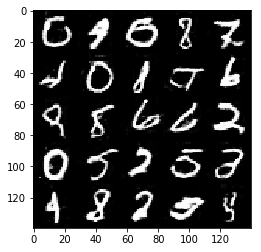

In [98]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 10

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/5... Discriminator Loss: 0.1326... Generator Loss: 2.5001
Epoch 1/5... Discriminator Loss: 0.0756... Generator Loss: 3.3109
Epoch 1/5... Discriminator Loss: 0.7134... Generator Loss: 10.2246
Epoch 1/5... Discriminator Loss: 0.4362... Generator Loss: 1.5448
Epoch 1/5... Discriminator Loss: 0.4870... Generator Loss: 1.6885
Epoch 1/5... Discriminator Loss: 0.4468... Generator Loss: 2.9845
Epoch 1/5... Discriminator Loss: 0.4133... Generator Loss: 3.0002
Epoch 1/5... Discriminator Loss: 0.2735... Generator Loss: 2.4746
Epoch 1/5... Discriminator Loss: 0.4341... Generator Loss: 2.7408
Epoch 1/5... Discriminator Loss: 1.1088... Generator Loss: 0.6880
Epoch 1/5... Discriminator Loss: 0.9212... Generator Loss: 0.8216
Epoch 1/5... Discriminator Loss: 1.1731... Generator Loss: 2.7519
Epoch 1/5... Discriminator Loss: 0.6010... Generator Loss: 2.7161
Epoch 1/5... Discriminator Loss: 0.6283... Generator Loss: 1.2897
Epoch 1/5... Discriminator Loss: 0.6988... Generator Loss: 1.1604
Epoch 1/5

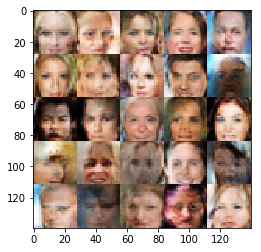

Epoch 2/5... Discriminator Loss: 0.5474... Generator Loss: 1.4735
Epoch 2/5... Discriminator Loss: 0.9190... Generator Loss: 0.6929
Epoch 2/5... Discriminator Loss: 0.7957... Generator Loss: 0.8702
Epoch 2/5... Discriminator Loss: 0.9987... Generator Loss: 0.6392
Epoch 2/5... Discriminator Loss: 0.6276... Generator Loss: 1.3935
Epoch 2/5... Discriminator Loss: 0.5762... Generator Loss: 1.4250
Epoch 2/5... Discriminator Loss: 0.9060... Generator Loss: 1.3312
Epoch 2/5... Discriminator Loss: 0.6208... Generator Loss: 1.0996
Epoch 2/5... Discriminator Loss: 0.9317... Generator Loss: 0.8267
Epoch 2/5... Discriminator Loss: 1.0810... Generator Loss: 0.5947
Epoch 2/5... Discriminator Loss: 0.8818... Generator Loss: 0.7881
Epoch 2/5... Discriminator Loss: 0.7892... Generator Loss: 1.5772
Epoch 2/5... Discriminator Loss: 1.0119... Generator Loss: 0.7650
Epoch 2/5... Discriminator Loss: 0.6146... Generator Loss: 1.2359
Epoch 2/5... Discriminator Loss: 0.8265... Generator Loss: 0.8874
Epoch 2/5.

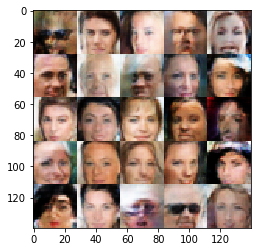

Epoch 3/5... Discriminator Loss: 1.3524... Generator Loss: 0.4305
Epoch 3/5... Discriminator Loss: 0.9609... Generator Loss: 1.5648
Epoch 3/5... Discriminator Loss: 0.6673... Generator Loss: 1.8846
Epoch 3/5... Discriminator Loss: 0.9177... Generator Loss: 0.7022
Epoch 3/5... Discriminator Loss: 0.7058... Generator Loss: 1.6176
Epoch 3/5... Discriminator Loss: 0.6684... Generator Loss: 1.0156
Epoch 3/5... Discriminator Loss: 0.7170... Generator Loss: 1.5113
Epoch 3/5... Discriminator Loss: 0.7334... Generator Loss: 1.4360
Epoch 3/5... Discriminator Loss: 0.7491... Generator Loss: 0.9702
Epoch 3/5... Discriminator Loss: 0.6019... Generator Loss: 1.4760
Epoch 3/5... Discriminator Loss: 0.6398... Generator Loss: 1.2814
Epoch 3/5... Discriminator Loss: 0.6309... Generator Loss: 1.4263
Epoch 3/5... Discriminator Loss: 0.6064... Generator Loss: 1.6053
Epoch 3/5... Discriminator Loss: 0.6045... Generator Loss: 1.4013
Epoch 3/5... Discriminator Loss: 0.7156... Generator Loss: 1.1602
Epoch 3/5.

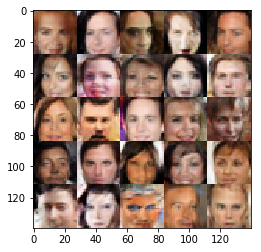

Epoch 4/5... Discriminator Loss: 0.7939... Generator Loss: 0.8539
Epoch 4/5... Discriminator Loss: 1.0708... Generator Loss: 0.6418
Epoch 4/5... Discriminator Loss: 0.7809... Generator Loss: 1.0151
Epoch 4/5... Discriminator Loss: 0.8338... Generator Loss: 1.5813
Epoch 4/5... Discriminator Loss: 0.9103... Generator Loss: 0.6894
Epoch 4/5... Discriminator Loss: 0.7864... Generator Loss: 0.7973
Epoch 4/5... Discriminator Loss: 0.7223... Generator Loss: 1.0685
Epoch 4/5... Discriminator Loss: 0.6875... Generator Loss: 1.0982
Epoch 4/5... Discriminator Loss: 0.6390... Generator Loss: 1.3324
Epoch 4/5... Discriminator Loss: 0.6576... Generator Loss: 1.5527
Epoch 4/5... Discriminator Loss: 1.0867... Generator Loss: 0.5577
Epoch 4/5... Discriminator Loss: 1.1640... Generator Loss: 0.4944
Epoch 4/5... Discriminator Loss: 0.7480... Generator Loss: 1.0781
Epoch 4/5... Discriminator Loss: 0.9062... Generator Loss: 0.6837
Epoch 4/5... Discriminator Loss: 1.0121... Generator Loss: 1.8375
Epoch 4/5.

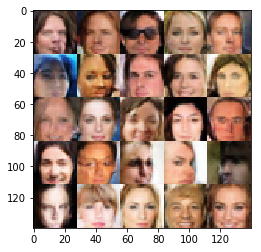

Epoch 5/5... Discriminator Loss: 0.5354... Generator Loss: 2.4609
Epoch 5/5... Discriminator Loss: 0.9250... Generator Loss: 0.6957
Epoch 5/5... Discriminator Loss: 0.4142... Generator Loss: 1.3988
Epoch 5/5... Discriminator Loss: 0.9210... Generator Loss: 0.6899
Epoch 5/5... Discriminator Loss: 0.7029... Generator Loss: 1.0328
Epoch 5/5... Discriminator Loss: 0.8330... Generator Loss: 0.8842
Epoch 5/5... Discriminator Loss: 0.7006... Generator Loss: 1.3480
Epoch 5/5... Discriminator Loss: 0.6252... Generator Loss: 1.2081
Epoch 5/5... Discriminator Loss: 0.5148... Generator Loss: 1.4435
Epoch 5/5... Discriminator Loss: 0.5936... Generator Loss: 1.4267
Epoch 5/5... Discriminator Loss: 0.5992... Generator Loss: 1.1839
Epoch 5/5... Discriminator Loss: 0.6321... Generator Loss: 1.1569
Epoch 5/5... Discriminator Loss: 0.5402... Generator Loss: 1.2811
Epoch 5/5... Discriminator Loss: 0.6180... Generator Loss: 1.3725
Epoch 5/5... Discriminator Loss: 0.7634... Generator Loss: 0.8716
Epoch 5/5.

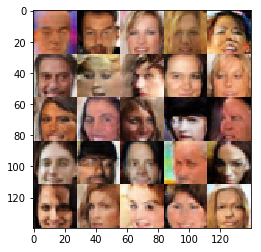

In [99]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 5

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.